### Hackathon (Data Science Part)

#### Author : Saiful Hasan [LinkedIn](https://www.linkedin.com/in/saifulhasan22/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
import requests
import nltk
import re
from nltk.stem import WordNetLemmatizer #Import lemmatizer
from nltk.tokenize import RegexpTokenizer # Import Tokenizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

RANDOM_STATE = 42

%matplotlib inline 

### Table of Contents

- [The role of data scientists in this project](#The-role-of-data-scientists-in-this-project)
- [Probable data source](#Probable-data-source)
- [The probable types of analysis Data scientist could do in such problems](#The-probable-types-of-analysis-Data-scientist-could-do-in-such-problems)
- [Data protection laws](#Data-protection-laws)
- [Limitations and our chosen data sources](#Limitations-and-our-chosen-data-sources)
- [Useful functions](#Useful-functions)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Consumers' technology Adaptation](#Consumers'-technology-Adaptation)
    - [Consumers' attitude towards Kiosk](#Consumers'-attitude-towards-Kiosk)
    - [Consumers' attitude towards the mask](#Consumers'-attitude-towards-the-mask)
    - [Consumers' attitude towards social distancing](#Consumers'-attitude-towards-social-distancing)
- [Reference](#[Reference)

### The role of data scientists in this project

Data science can be a very useful tool for any kind of decision-making process at any stage of a product or service. In our project, we aimed to propose a creative technology solution to limit contact and encourage social distancing practices on the event site. Since it's a new technology solution, we need to do data analysis before we start the system, even after we start the system. Besides, we would be utilizing the data science techniques before we start the system to build models to predict or at least get broader pictures of the prospects. We need to use the data science techniques along the way after we introduce the new innovative technology solutions in the target market for multiple reasons.

- To understand the consumer reaction and attitude towards our new contact-less check-in system. It's is essential to upgrade our system over time according to the consumers' demand and expectations.
- To predict the cost-benefit analysis and profitability.
- To understand consumer behavior, which is essential to establish consumer loyalty.
- to get in depth insight for our next innovative solution.


### Probable data source

- Survey data; 
    - the customized survey specifically on our check-in system
- Social media platforms (such as Facebook, Twitter, Reddit); 
    - we could use the posts, comments, and discussions 
- Consumer reviews, ratings from several sources; 
    - on-site review options, reviews posted on our website/app, or reviews or rating posted on other review pages/portals
- The data we get from our system; 
    - Behavior related to check-in and app usage

### The probable types of analysis Data scientist could do in such problems

- Graphic visualization of the user usage to see consumer behavioral change 
- Sentiment analysis of users' posts, comments, reviews, ratings
- Investiagting the usage trend
- Figuring out the features that can predict the future usage 
- Time-series analysis to predict the future usage
- Porift variance analysis before and after introducing the new check-in system


### Data protection laws

### Limitations and our chosen data sources

However, since its completely a new solution in the market, and also the current phenomena are unprecedented, we don't have any historical data specifically related to the problem we are facing now as well the solution we are proposing. In such cases, We have decided to look into other relevant data to get somehow a picture to see how our new contactless check-in system might work out. So, the corresponding data we chose to look into the are:

- technology adaptation rate of our consumers. There are several parameters to look into to know how a consumer segment is technological adaptive. However, since in our new contact-less solution, the consumers need to use the internet at some point, we chose to see how much our target consumers use the internet as their technological acceptance rate. 

- since the consumers need to use the kiosk at some point to make the check-in, we chose to see the acceptance of kiosk in the market. To see this, we used the LINK NYC kiosk usage data. 

- then we used scraped data from subreddit and twitters to see our consumers' attitude to social distance, mask, and wrist band. The reasons we decided to investigate these factors are: 
1) we are introducing this new contact-less check-in system to keep the social distance, and
2) on-site, our user can do check-in using their mobile app, or bar-code printed mask or wrist band. If the user doesn't want to or cannot use a mobile app to scan at the kiosk, the consumer could use a mask or wrist band to make the check-in at kiosk. Thus we thought that investigating these features would give us an overall idea of how consumers might react to our new innovative system.


### Useful functions

**Function to pull data from subreddit**

In [17]:
#adopted from Mahdi Shadkam-Farrokhi's code

def query_pushshift(subreddit, kind = 'submission', day_window = 30, n = 20):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'is_self']
    
    # establish base url and stem
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}" # also known as the "API endpoint" 
    stem1 = f"{BASE_URL}?q="
    stem = f"{BASE_URL}?subreddit={subreddit}&size=500" # always pulling max of 500
    
    # instantiate empty list for temp storage
    posts = []
    
    # implement for loop with `time.sleep(2)`
    for i in range(1, n + 1):
        URL = "{}&after={}d".format(stem, day_window * i)
        print("Querying from: " + URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        posts.append(df)
        time.sleep(2)
    
    # pd.concat storage list
    full = pd.concat(posts, sort=False)
    
    # if submission
    if kind == "submission":
        # select desired columns
        full = full[SUBFIELDS]
        # drop duplicates
        full.drop_duplicates(inplace = True)
        # select `is_self` == True
        full = full.loc[full['is_self'] == True]

    # create `timestamp` column
    full['timestamp'] = full["created_utc"].map(dt.date.fromtimestamp)
    
    print("Query Complete!")    
    return full 

**Function to clean the text data collected from from subreddit/twitter**

In [3]:
#writing function to clean title
#adopted and modified from https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-one-5ac2d06b63fb
#adopted and modified from https://towardsdatascience.com/getting-your-text-data-ready-for-your-natural-language-processing-journey-744d52912867
#adopted and modified Matt Brems code 

def review_to_title(title):
    
    # Remove non-letters.
    title = re.sub("[^a-zA-Z]", " ", title)
    
    # Convert to lower case
    title = title.lower()
    
    # Remove hashtags
    title = re.sub(r'#\w*', '', title)
    
    # Remove HTML special entities (e.g. &amp;)
    title = re.sub(r'\&\w*;', '', title)
    
    #punctuation
    title = re.sub(r'[?|!|\'|#]', r'', title)
    
    # Remove hyperlinks
    title = re.sub(r'https?:\/\/.*\/\w*', '', title)
    
    # Remove whitespace (including new line characters)
    title = re.sub(r'\s\s+', ' ', title)
    
    return title

**Function to lemmatize the text data collected from from subreddit/twitter**

In [4]:
# Lemmatizing
# ref : https://www.guru99.com/stemming-lemmatization-python-nltk.html
# ref : Sarah Scolnik github 

lemmatizer = WordNetLemmatizer()
def lemmatize_words(title):
    words = title.split()
    lemma_words = ''
    for word in words:
        lemma_words += (lemmatizer.lemmatize(word) + ' ')
    return lemma_words

**Function to do sentiment analysis**

In [5]:
# function definitions from https://github.com/fuzzymuzzywuzzy/sentiment-analysis-twitter
analyzer = SentimentIntensityAnalyzer() #instantiates the Vader Analyzer

def sentiment_score_compound(sentence):
    score = analyzer.polarity_scores(sentence) #gets the sentmiment score from VADER
    return score['compound'] #returns the compoud score

def sentiment_score_pos(sentence):
    score = analyzer.polarity_scores(sentence) #gets the snetiment score from VADER
    return score['pos'] #returns the positive score

def sentiment_score_neg(sentence):
    score = analyzer.polarity_scores(sentence) #gets the sentiment score from VADER
    return score['neg'] #returns the negative score

def sentiment_score_neu(sentence):
    score = analyzer.polarity_scores(sentence) #gets the sentiment score from VADER
    return score['neu'] #returns the neutral score

**Function to do sentiment analysis for text data collected from from subreddit**

In [87]:
# Tangina's sentiment dataframe compiling function
# references functions from https://github.com/fuzzymuzzywuzzy/sentiment-analysis-twitter

def df_sentiment_compiler(file, base_path):
    """
    This function takes in a csv file as a pandas dataframe containing at minimum a column named 'text'
    and returns a dataframe containing sentiment scores.
    
    The function cleans the file by removing any extra columns and removing rows with no text.
    
    The function also implements SentimentIntensityAnalyzer score functions derived from the vaderSentiment package.
    These scores are then added into new columns in the dataframe.
    -----------------------------------------------------
    
    file(str)      : name of csv file
    
    base_path(str) : file location of csv file
    
    ----------------------------------------------
    
    """
    
    
    
    # read in file, drop excess columns, drop nans and reset index, and convert date object to datetime
    df = pd.read_csv(f'{base_path}{file}') #reads the dataframe
    df.reset_index(drop=True, inplace=True)
    
    # instantiate empty lists
    pos_list = [] #positive list
    neg_list = [] #negative list
    neu_list = [] #neutral list
    comp_list = [] #composite list

    # read in each tweet and pass through sentiment scorer, save scores in list
    for i in range(0,len(df)):
        
        selftext = df['title'][i] #calls a particular cell as tweet variable
        
        pos = sentiment_score_pos(selftext) #grabs the positive score of the tweet
        pos_list.append(pos) #appends the positive score to the positive list
        
        neg = sentiment_score_neg(selftext) #grabs the negative score of the tweet
        neg_list.append(neg) #appends the positive score to the positive list
        
        neu = sentiment_score_neu(selftext) #grabs the neutral score of the tweet
        neu_list.append(neu) #appends the positive score to the positive list
        
        comp = sentiment_score_compound(selftext) #grabs the composite score of the tweet
        comp_list.append(comp) #appends the positive score to the positive list
        
    
    # add new column to dataframe containing sentiment scores
    df['pos_score'] = np.array(pos_list) #creates a positive score dataframe column
    df['neg_score'] = np.array(neg_list) #creates a negative score dataframe column
    df['neu_score'] = np.array(neu_list) #creates a neutral score dataframe column
    df['comp_score'] = np.array(comp_list) #creates a composite score dataframe column
    
    
    # return new dataframe
    return df #returns the dataframe

**Function to do sentiment analysis for text data collected from from twitter**

In [77]:
# adopted code from Tangina's sentiment dataframe compiling function
# references functions from https://github.com/fuzzymuzzywuzzy/sentiment-analysis-twitter

def df_sentiment_compiler(file, base_path):
    """
    This function takes in a csv file as a pandas dataframe containing at minimum a column named 'text'
    and returns a dataframe containing sentiment scores.
    
    The function cleans the file by removing any extra columns and removing rows with no text.
    
    The function also implements SentimentIntensityAnalyzer score functions derived from the vaderSentiment package.
    These scores are then added into new columns in the dataframe.
    -----------------------------------------------------
    
    file(str)      : name of csv file
    
    base_path(str) : file location of csv file
    
    ----------------------------------------------
    
    """
    
    
    
    # read in file, drop excess columns, drop nans and reset index, and convert date object to datetime
    df = pd.read_csv(f'{base_path}{file}') #reads the dataframe
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # instantiate empty lists
    pos_list = [] #positive list
    neg_list = [] #negative list
    neu_list = [] #neutral list
    comp_list = [] #composite list

    # read in each tweet and pass through sentiment scorer, save scores in list
    for i in range(0,len(df)):
        
        selftext = df['text'][i] #calls a particular cell as tweet variable
        
        pos = sentiment_score_pos(selftext) #grabs the positive score of the tweet
        pos_list.append(pos) #appends the positive score to the positive list
        
        neg = sentiment_score_neg(selftext) #grabs the negative score of the tweet
        neg_list.append(neg) #appends the positive score to the positive list
        
        neu = sentiment_score_neu(selftext) #grabs the neutral score of the tweet
        neu_list.append(neu) #appends the positive score to the positive list
        
        comp = sentiment_score_compound(selftext) #grabs the composite score of the tweet
        comp_list.append(comp) #appends the positive score to the positive list
        
    
    # add new column to dataframe containing sentiment scores
    df['pos_score'] = np.array(pos_list) #creates a positive score dataframe column
    df['neg_score'] = np.array(neg_list) #creates a negative score dataframe column
    df['neu_score'] = np.array(neu_list) #creates a neutral score dataframe column
    df['comp_score'] = np.array(comp_list) #creates a composite score dataframe column
    
    
    # return new dataframe
    return df #returns the dataframe

### Exploratory Data Analysis

#### Consumers' technology Adaptation

In [7]:
#read data
technology_adaptation = pd.read_csv('usa_technology_adaptation.csv')

In [8]:
#show the first 5 rows
technology_adaptation.head()

,Entity,Code,Year,Individuals using the Internet (% of population) (% of population)
0,United States,USA,1990,0.784729
1,United States,USA,1991,1.163194
2,United States,USA,1992,1.724203
3,United States,USA,1993,2.271673
4,United States,USA,1994,4.862781


In [10]:
#Narrowed down the data and make a dataframe of data from 200o to 2016
technology_adaptation_2000 = technology_adaptation[technology_adaptation['Year'] > 1999]

In [11]:
#show the narrowed down data
technology_adaptation_2000.head(2)

,Entity,Code,Year,Individuals using the Internet (% of population) (% of population)
10,United States,USA,2000,43.079163
11,United States,USA,2001,49.080832


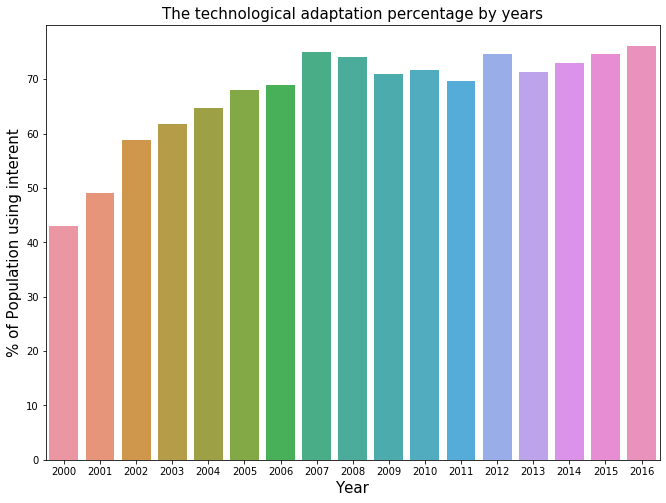

In [12]:
#plotting the data

fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax = sns.barplot(technology_adaptation_2000['Year'], technology_adaptation_2000['Individuals using the Internet (% of population) (% of population)'])

plt.xlabel('Year', fontsize = 15)
plt.ylabel('% of Population using interent', fontsize = 15)
plt.title('The technological adaptation percentage by years', fontsize = 15)
plt.show()


We see that the percentage of the population using the internet is increasing over the year. The data we presented are from 2016, and today is 2020, so we can expect that the percentage is now already around 80%. Therefore,  We can assume that our users won't face any difficulty through the process.

#### Consumers' attitude towards Kiosk

In [13]:
#read the data
kiosk = pd.read_csv('nylink.csv')

In [14]:
#show the dataframe
kiosk

,Year,Cumulative Sessions To Date
0,2016,73839957
1,2017,509915691
2,2018,994931692


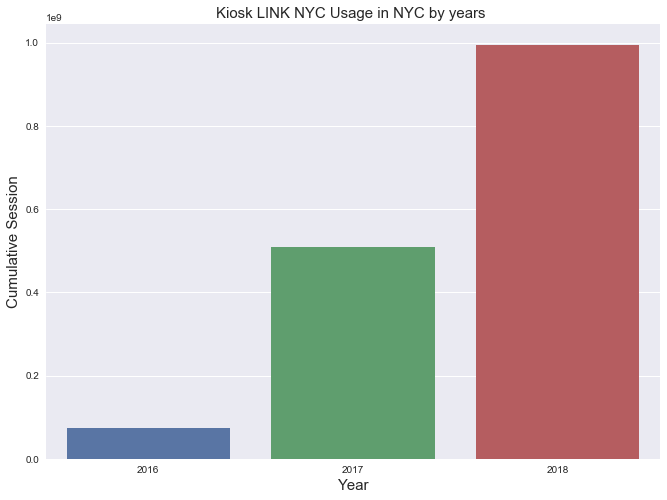

In [97]:
#plotting the data

fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax = sns.barplot(kiosk['Year'], kiosk['Cumulative Sessions To Date'])

plt.xlabel('Year', fontsize = 15)
plt.ylabel('Cumulative Session', fontsize = 15)
plt.title('Kiosk LINK NYC Usage in NYC by years ', fontsize = 15)
plt.show()


We observed that over the year from 2016 to 2018, the NYC LINK usage increased exponentially, and that gives us hope that the consumers would widely accept our contact-less service through the kiosk. Moreover, we observed that at the beginning, the usages were pretty low, so it gives us a hint that even if we experience lower acceptance in the first year, we should continue using the system to give consumers a chance to get used to it.  

#### Consumers' attitude towards the wrist band

Here we chose to analyze data from one of our competitors Disney World who also have check-in option using wrist band named magic-band

In [18]:
#pulling data from subreddit using the function 

disney = query_pushshift("WaltDisneyWorld")

Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=WaltDisneyWorld&size=500&after=30d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=WaltDisneyWorld&size=500&after=60d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=WaltDisneyWorld&size=500&after=90d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=WaltDisneyWorld&size=500&after=120d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=WaltDisneyWorld&size=500&after=150d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=WaltDisneyWorld&size=500&after=180d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=WaltDisneyWorld&size=500&after=210d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=WaltDisneyWorld&size=500&after=240d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=WaltDisneyWorld&size=500&after=270d
Quer

In [19]:
#save the data in csv formate

disney.to_csv("./disney.csv", index = False)

In [23]:
#show the first two rows of the dataset

disney.head(2) 

,title,selftext,subreddit,created_utc,author,is_self,timestamp
0,Booking for 2021 - Covid restrictions?,[removed],WaltDisneyWorld,1592852289,J_Rhix,True,2020-06-22
1,Can’t buy an annual pass!,[removed],WaltDisneyWorld,1592855002,Dudeman1919,True,2020-06-22


In [92]:
#count vectorizing the the title 

count_vect = CountVectorizer(
                             analyzer = "word", 
                             stop_words = "english", 
                             max_features = 20,
                             ngram_range= (2,2)
                            )

df_words = count_vect.fit_transform(disney['title'])  #fit_transform the vectorizer
df_words = df_words.toarray() #output
covec_df = pd.DataFrame(df_words, columns = count_vect.get_feature_names())

In [93]:
#creating dataframe of the count vectorized phrases
covec_df = pd.DataFrame(df_words, columns = count_vect.get_feature_names()) # creating a dataframe

Text(0, 0.5, 'words')

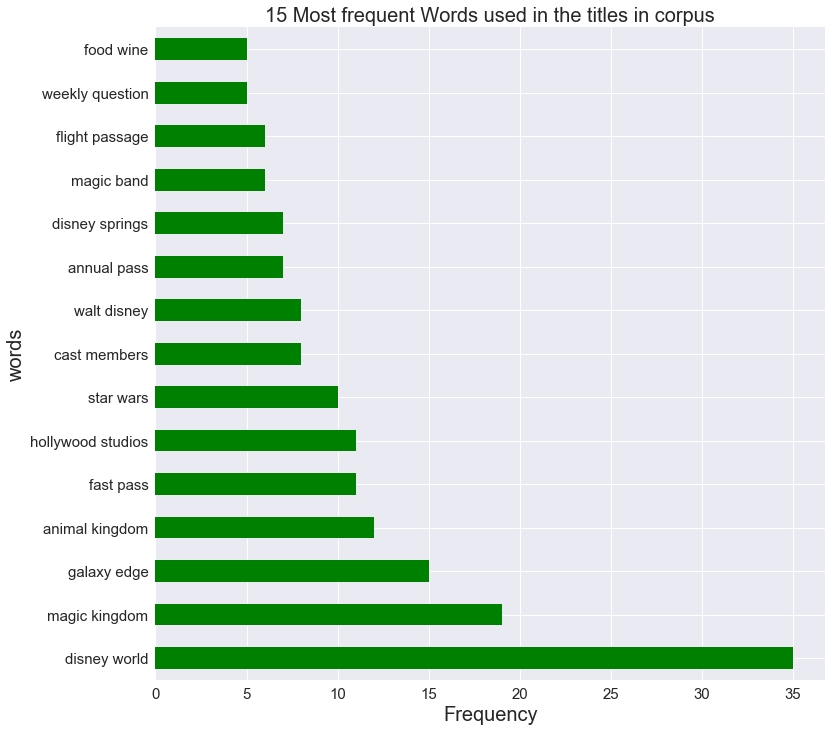

In [94]:
#plotting the most frequent words in the title in corpus

plt.style.use('seaborn')
plt.figure(figsize = (12,12))
covec_df.sum().sort_values(ascending=False)[:15].plot(kind = 'barh', color ='g', fontsize = 15)
plt.title("15 Most frequent Words used in the titles in corpus", fontsize = 20)
plt.xlabel('Frequency', fontsize =20)
plt.ylabel ('words', fontsize = 20)

In [32]:
#read the customized data for magic band. this includes subreddit submission only have magic band in it.  

magic_band = pd.read_csv('./magic_band_2.csv')

In [88]:
#produce sentiment score using the function and the scores shows as columns in the dataset

base = './'
sentiment_score_magic_band = df_sentiment_compiler('./data/magic_band.csv', base)

In [89]:
#creating dataset for the plotting

data = [['positive score', sentiment_score_magic_band['pos_score'].mean()], \
                ['negative score', sentiment_score_magic_band['neg_score'].mean()], \
            ['neutral score', sentiment_score_magic_band['neu_score'].mean()]]
df = pd.DataFrame(data, columns = ['sentiments', 'scores'])

In [90]:
#showing the mean scores of the seniment analysis 
df

,sentiments,scores
0,positive score,0.110517
1,negative score,0.036849
2,neutral score,0.852634


Text(0, 0.5, 'scores')

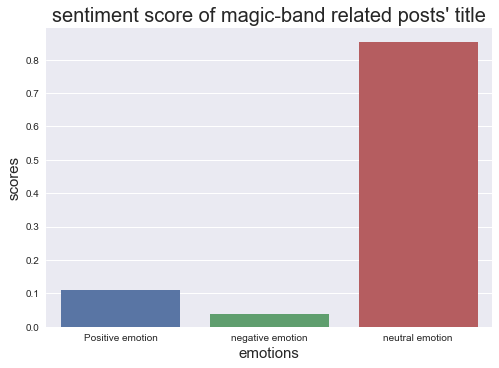

In [91]:
#plotting the sentiment score means

sns.barplot(x = [ 'Positive emotion', 'negative emotion', 'neutral emotion'], y = df['scores'])
plt.title("sentiment score of magic-band related posts' title", fontsize = 20)
plt.xlabel('emotions', fontsize =15)
plt.ylabel ('scores', fontsize = 15)

We see that most of the posts related to the magic band are neutral. However, we see that the positive emotion score is higher than the negative scores, and this is a good sign. Higher neutral emotions could also be interpreted that our consumer might not react much with our new scanning system by wrist band, which is also good in some senses.  

#### Consumers' attitude towards the mask

In [51]:
#pulling data from subreddit using the function 


mask = query_pushshift("Masks")

Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&after=30d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&after=60d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&after=90d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&after=120d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&after=150d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&after=180d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&after=210d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&after=240d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&after=270d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Masks&size=500&afte

In [53]:
#creating csv file

mask.to_csv("./mask.csv", index = False)

In [56]:
#read the dataframe

mask_df = pd.read_csv('./mask.csv')

In [58]:
#producingsentiments scores using the function and the scores shows as columns in the dataset

base = './'
sentiment_score_maks = df_sentiment_compiler('./data/mask.csv', base)

In [69]:
#creating dataset for plotting

data_2 = [['positive score', sentiment_score_maks['pos_score'].mean()], \
                ['negative score', sentiment_score_maks['neg_score'].mean()], \
            ['neutral score', sentiment_score_maks['neu_score'].mean()]]
df_2 = pd.DataFrame(data, columns = ['sentiments', 'scores'])

In [70]:
#showing the seniment score means 

df_2

,sentiments,scores
0,positive score,0.121506
1,negative score,0.037406
2,neutral score,0.841096


Text(0, 0.5, 'scores')

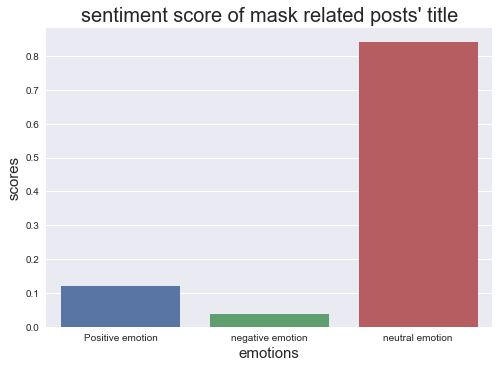

In [84]:
#plotting the sentiment score means 

sns.barplot(x = [ 'Positive emotion', 'negative emotion', 'neutral emotion'], y = df_2['scores'])
plt.title("sentiment score of mask related posts' title", fontsize = 20)
plt.xlabel('emotions', fontsize =15)
plt.ylabel ('scores', fontsize = 15)

We see the same score comparison here as well. We could interpret this as the same we did for the wrist band. Positive insight that more positive emotions than the negative emotions. 

#### Consumers' attitude towards social distancing 

*Data source: The tweets with social distance query are taken from previously collected dataset for one of the projects during General Assembly's data science immersive program. We used only tweets from new York city to keep consistency with our above dataset on kiosk*

In [65]:
#reading the twitter data previously collected

twitter_data = pd.read_csv('./tweet/shaved_nyc.csv')

In [66]:
#narrowed it down to only query for social distancing 

social_distancing_data = twitter_data[twitter_data['search_term'] == 'social distancing']

In [68]:
#showing the first rows 

social_distancing_data.head(2)

,tweet_id,text,tweet_date,search_term,city,lat,long,radius,query_start
1,1.251990e+18,all these morons going outside and protesting ...,19/04/2020 21:33,social distancing,"{'city': 'New York city', 'lat': 40.7128, 'lon...",40.7128,-74.006,10mi,12/04/2020 00:00
27,1.253090e+18,Quarantine bored #coronavirus #boredinthehous...,22/04/2020 22:53,social distancing,"{'city': 'New York city', 'lat': 40.7128, 'lon...",40.7128,-74.006,10mi,12/04/2020 00:00


In [78]:
#producing sentiment scores using the function and the scores shows as columns in the dataset

base = './tweet/'
sentiment_score_social_distancing =df_sentiment_compiler('shaved_nyc.csv', base)

In [79]:
#creating dataset for plotting 

data_3 = [['positive score', sentiment_score_social_distancing['pos_score'].mean()], \
                ['negative score', sentiment_score_social_distancing['neg_score'].mean()], \
            ['neutral score', sentiment_score_social_distancing['neu_score'].mean()]]
df_3 = pd.DataFrame(data, columns = ['sentiments', 'scores'])

In [83]:
#showing the sentiments score means 

df_3

,sentiments,scores
0,positive score,0.121506
1,negative score,0.037406
2,neutral score,0.841096


Text(0, 0.5, 'scores')

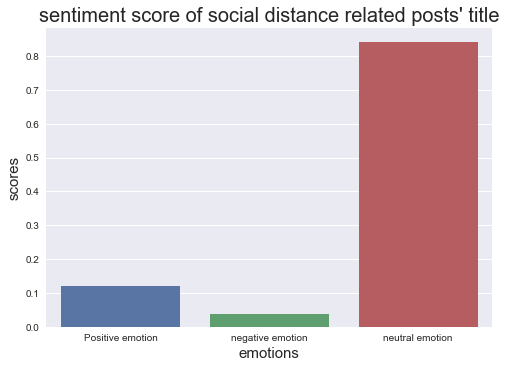

In [85]:
#plotting the sentiment score means 

sns.barplot(x = [ 'Positive emotion', 'negative emotion', 'neutral emotion'], y = df_3['scores'])
plt.title("sentiment score of social distance related posts' title", fontsize = 20)
plt.xlabel('emotions', fontsize =15)
plt.ylabel ('scores', fontsize = 15)

We see the same score comparison here as well. We could interpret this as the same we did for the wrist band. Positive insight that more positive emotions than the negative emotions. 

### Reference

[1] [Technology Adaptation](https://ourworldindata.org/technology-adoption)

[2] [LINK NYC](https://data.world/city-of-ny/69wu-b929)

[2] [subreddit Mask](https://www.reddit.com/r/Masks/)

[3] [subreddit Disney World](https://www.reddit.com/r/WaltDisneyWorld/)